In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
pd.set_option("display.max.columns", None)
df = pd.read_pickle('12_tasks.pkl')
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})


### Pie Charts

In [3]:
factors = ['alcohol_per_week','caffeine_per_day']
demo = df.xs('info',1)

caffeine_cat = pd.cut(demo[factors[1]],
                      [0,0.1,2,4,100],
                      include_lowest=True,
                      labels=['No Coffee', 'Some', 'Moderate','Excessive'],
                      ordered=True)

caffeine = pd.concat([caffeine_cat.value_counts(normalize=True).rename('proportion'),
                      caffeine_cat.value_counts().rename('obs')],axis=1)


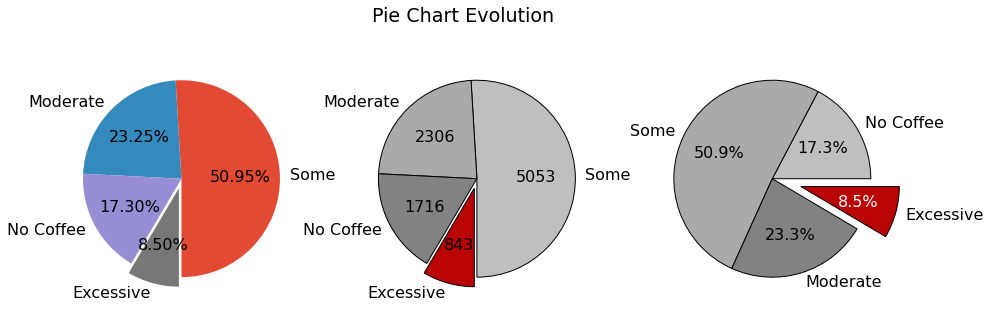

In [5]:
fig,ax = plt.subplots(1,3,figsize = (15,5))

total = caffeine.obs.sum()
ax[0].pie(caffeine.proportion, 
          labels=caffeine.index, 
          startangle=270,
          explode = (0, 0, 0, 0.1),
          autopct = '%1.2f%%')

ax[1].pie(caffeine.obs, 
          colors = ['#BFBFBF','#AAAAAA','#828282','#BA0404'],
          labels=caffeine.index, 
          startangle=270,
          wedgeprops = {'linewidth': 1,'edgecolor':'k'},
          explode = (0, 0, 0, 0.1),
          autopct = lambda x: f'{x*total / 100:1.0f}')


_, _, autotexts = ax[2].pie(caffeine.sort_index().proportion, 
          colors = ['#BFBFBF','#AAAAAA','#828282','#BA0404'],
          labels=caffeine.sort_index().index, 
          startangle=0,
          wedgeprops = {'linewidth': 1,'edgecolor':'k'},
          explode = (0, 0, 0, 0.3),
          autopct = '%1.1f%%')

autotexts[-1].set_color('white')

fig.suptitle('Pie Chart Evolution');


### Bar Plots

Text(0.5, 1.1, 'Cups of coffee per day')

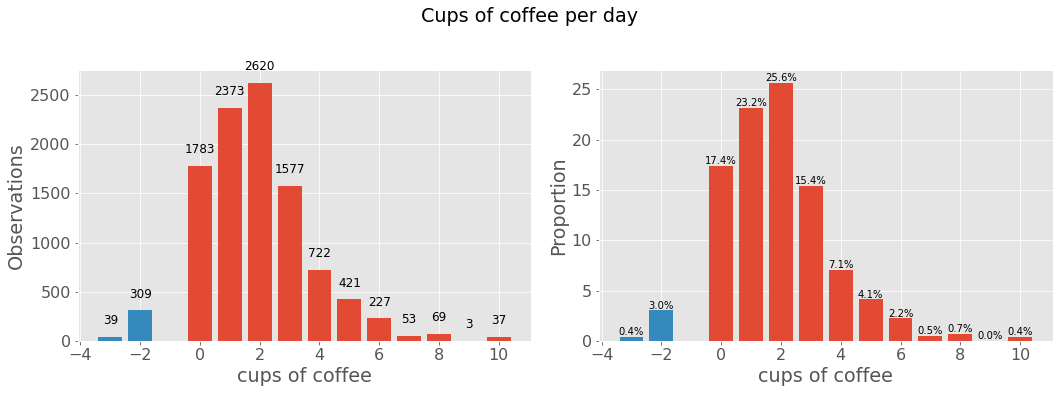

In [13]:

cups_per_day = demo[factors[1]].round(0).fillna(-2).astype(int)
caffeine = pd.concat([cups_per_day.value_counts(normalize=True).rename('proportion'),
                      cups_per_day.value_counts().rename('obs')],axis=1).sort_index()
caffeine = pd.concat([caffeine.iloc[:12],caffeine.iloc[12:].sum().rename(-3).to_frame().T])

fig,ax = plt.subplots(1,2,figsize = (15,5))

for data in [caffeine.query('index>=0'),
             caffeine.query('index<0')]:
    b1 = ax[0].bar(data.index,data.obs)
    b2 = ax[1].bar(data.index,data.proportion*100)
    ax[0].bar_label(b1,padding=10,fontsize=12,color='k')
    ax[1].bar_label(b2,padding=0.01,fontsize=10,color='k',fmt= '%.1f%%')

[ax[i].set_xlabel('cups of coffee') for i in range(2)]
ax[0].set_ylabel('Observations')
ax[1].set_ylabel('Proportion')

plt.tight_layout()

fig.suptitle('Cups of coffee per day', y=1.1 )

### Line Plots

In [24]:
age = df.xs('info',1).age
spatial_span = df.xs('spatial_span',1)
spatial_span.avg_ms_per_item = spatial_span.avg_ms_per_item.clip(0,5000)
spatial_span = pd.concat([age,spatial_span],axis=1).dropna()
ss_by_age = spatial_span.astype(float).groupby('age').agg(['mean','std'])
ss_by_age = ss_by_age.query('10 < age < 85')

Text(0.5, 1.01, 'Spatial_span')

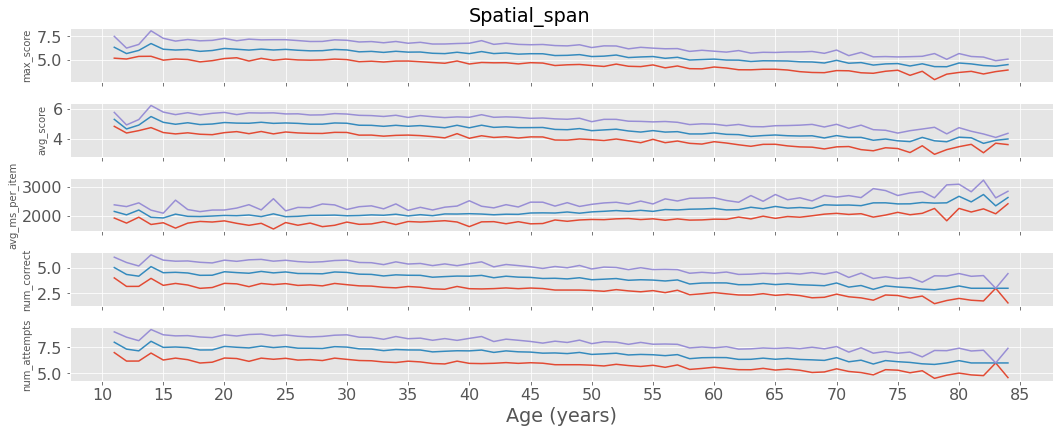

In [28]:
from matplotlib.ticker import  MultipleLocator 

fig,ax = plt.subplots(5,1,figsize=(15,6),sharex=True)
age = ss_by_age.index
for i,metric in enumerate(ss_by_age.columns.get_level_values(0).unique()):
    y = ss_by_age.xs(metric,1).to_numpy()
    lb,y,ub = y[:,0]-y[:,1], y[:,0], y[:,0]+y[:,1]
    for values,label in zip([lb,y,ub],['lower_bounds','mean','upper_bounds']):
        ax[i].plot(age,values,label=label)
        ax[i].set_ylabel(metric,fontsize=10)
        ax[i].xaxis.set_major_locator(MultipleLocator(5))

ax[-1].set_xlabel('Age (years)')
plt.tight_layout()
fig.suptitle('Spatial_span', y=1.01 )

In [30]:
domains = df.columns.get_level_values(0)
completed = pd.DataFrame()
for domain in domains:
    completed[domain] = df[domain].notna().sum(axis=1)>0
complete_obs = completed.sum().sort_values()    

(0.0, 11000.0)

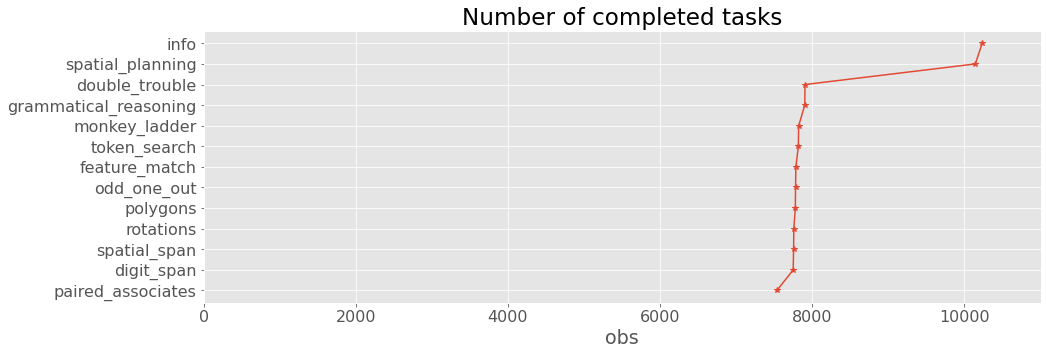

In [45]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(complete_obs.values,complete_obs.index,marker='*')
ax.set_title('Number of completed tasks')
ax.set_xlabel('obs')
ax.set_xlim(0,11000)

Text(0.5, 1.01, 'Two additional different views')

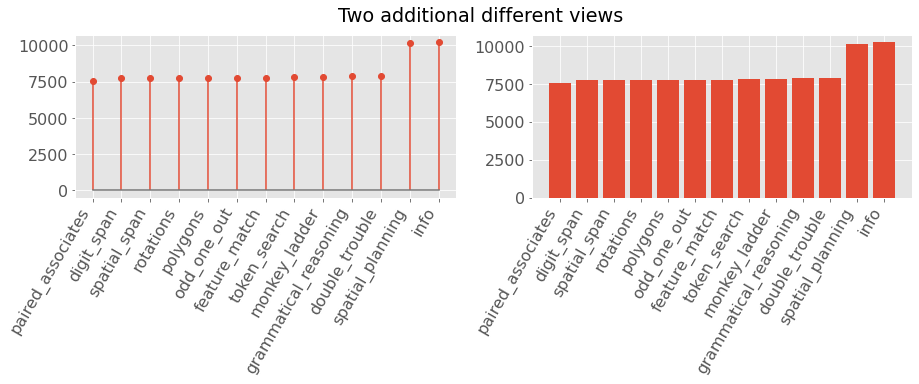

In [46]:
fig,ax = plt.subplots(1,2,figsize=(15,3))
ax[0].stem(complete_obs)
ax[1].bar(complete_obs.index,complete_obs.values,0.8)
for i in range(2):
    ax[i].set_xticks(np.arange(complete_obs.shape[0]))
    ax[i].set_xticklabels(complete_obs.index,rotation=60,ha='right');

fig.suptitle('Two additional different views', y=1.01 )

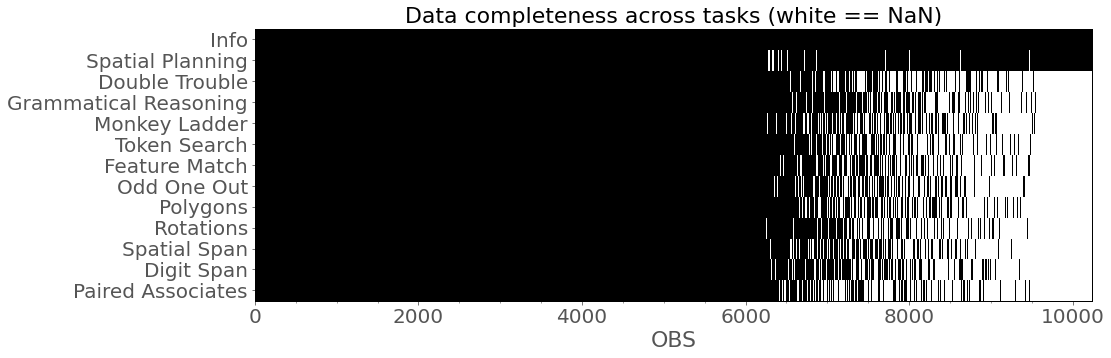

In [51]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

tasks =  set(df.columns.get_level_values(0))
completeness = {}
for task in tasks:
    completeness[task] = df.xs(task,1).notna().sum(axis=1)>0
    
completeness = pd.concat(completeness,axis=1)   
obs_order = completeness.sum(axis=1).sort_values(ascending=False).index
col_order = completeness.sum().sort_values().index
completeness = completeness.loc[obs_order,col_order].reset_index(drop=True)


fig,ax = plt.subplots(figsize=(15,5))
ax.pcolor(completeness.T.to_numpy(),cmap='Greys')

ax.xaxis.set_major_locator(MultipleLocator(2000))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(0,df.shape[0])
ax.set_yticks(np.arange(0.5,len(tasks),1))
labels = completeness.columns.str.replace('_', ' ').str.title()
ax.set_yticklabels(labels,fontsize=20)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(True)
ax.spines[['top', 'right', 'left', 'bottom']].set_color('k')
ax.set_title('Data completeness across tasks (white == NaN)',fontsize=22)
ax.set_xticklabels(ax.get_xticks().astype(int),fontsize=20)
ax.set_xlabel('OBS',fontsize=22)
fig.savefig('completeness.png', bbox_inches = 'tight')

In [77]:
set(score).intersection(df_.columns)

set()

,spatial_planning,monkey_ladder,rotations,feature_match,polygons,digit_span,paired_associates,double_trouble,odd_one_out,token_search,spatial_span,grammatical_reasoning
"(info, user)",,,,,,,,,,,,
45312,20.0,8.0,109.0,100.0,26.0,5.0,3.0,44.0,14.0,8.0,5.0,19.0
45315,19.0,7.0,61.0,156.0,63.0,6.0,6.0,28.0,11.0,8.0,6.0,25.0
45318,14.0,7.0,132.0,145.0,62.0,6.0,4.0,44.0,15.0,7.0,6.0,17.0
45319,23.0,NaN,144.0,157.0,72.0,7.0,5.0,49.0,8.0,NaN,5.0,21.0
45320,18.0,8.0,NaN,90.0,55.0,7.0,6.0,18.0,NaN,NaN,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102962,32.0,6.0,0.0,7.0,-4.0,6.0,4.0,2.0,2.0,3.0,6.0,0.0
103072,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103261,16.0,7.0,116.0,132.0,60.0,6.0,6.0,14.0,9.0,3.0,6.0,15.0


In [109]:
df.head(3).T
scores = {}
score = ['max_score','final_score']
for task in tasks:
    df_ = df.xs(task,1)
    col = set(score).intersection(df_.columns)
    scores[task] = df_[col]
scores = pd.concat(scores,axis=1).droplevel(1,1).astype(float)
# scores  = scores.astype(float).dropna().apply(zscore)

In [112]:
scores.quantile([0.01,0.99])

,spatial_planning,monkey_ladder,rotations,feature_match,polygons,digit_span,paired_associates,double_trouble,odd_one_out,token_search,spatial_span,grammatical_reasoning
0.01,0.0,5.0,-11.0,19.83,-7.00,3.0,2.0,-8.0,-6.0,0.0,3.0,2.0
0.99,52.0,11.0,170.0,196.00,96.24,11.0,7.0,61.0,17.0,12.0,8.0,30.0


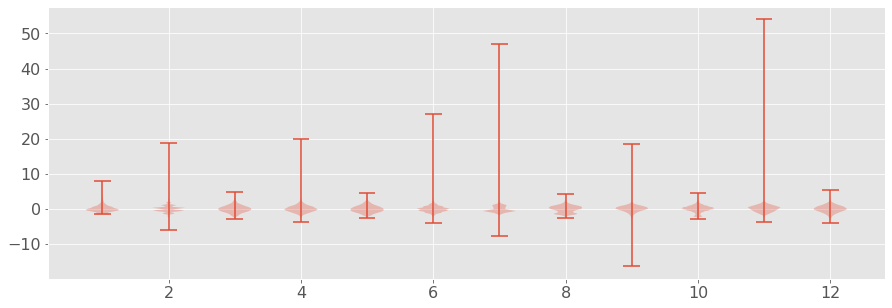

In [105]:
import seaborn as sns 
from scipy.stats import zscore

fig,ax = plt.subplots(figsize=(15,5))
ax.violinplot(scores);


### Histograms

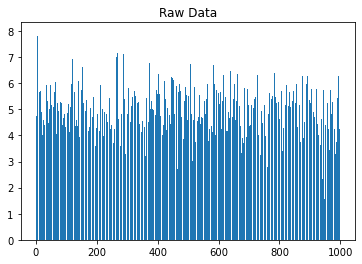

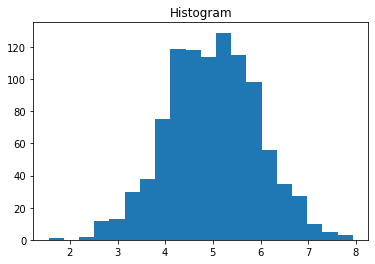

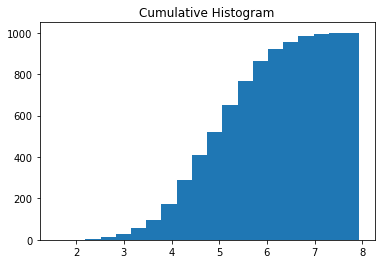

In [ ]:
demo.query('0 < age < 100').groupby('sex').age.hist(alpha=0.5,legend=True,figsize=(15,5));

plt.hist(n, bins=20)
plt.title("Histogram")
plt.show()

plt.hist(n, cumulative=True, bins=20)
plt.title("Cumulative Histogram")
plt.show()

### Scatter Plots

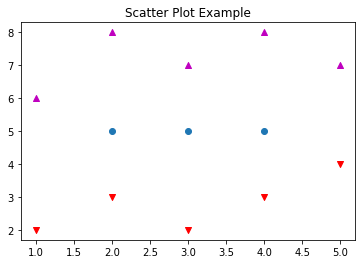

In [ ]:
x1 = [2, 3, 4]
y1 = [5, 5, 5]

x2 = [1, 2, 3, 4, 5]
y2 = [2, 3, 2, 3, 4]
y3 = [6, 8, 7, 8, 7]

# Markers: https://matplotlib.org/api/markers_api.html

plt.scatter(x1, y1)
plt.scatter(x2, y2, marker='v', color='r')
plt.scatter(x2, y3, marker='^', color='m')
plt.title('Scatter Plot Example')
plt.show()

### Stack Plots

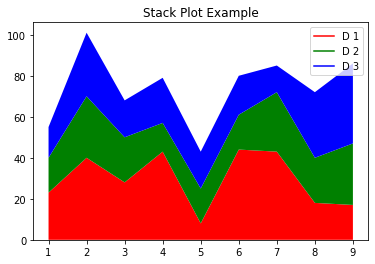

In [ ]:
idxes = [ 1,  2,  3,  4,  5,  6,  7,  8,  9]
arr1  = [23, 40, 28, 43,  8, 44, 43, 18, 17]
arr2  = [17, 30, 22, 14, 17, 17, 29, 22, 30]
arr3  = [15, 31, 18, 22, 18, 19, 13, 32, 39]

# Adding legend for stack plots is tricky.
plt.plot([], [], color='r', label = 'D 1')
plt.plot([], [], color='g', label = 'D 2')
plt.plot([], [], color='b', label = 'D 3')

plt.stackplot(idxes, arr1, arr2, arr3, colors= ['r', 'g', 'b'])
plt.title('Stack Plot Example')
plt.legend()
plt.show()

### fill_between and alpha

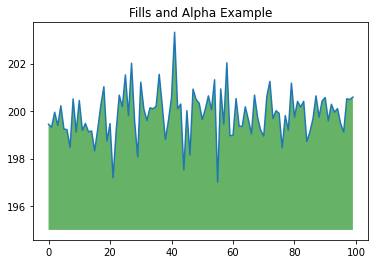

In [ ]:
ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Fills and Alpha Example")
plt.show()

### Subplotting using Subplot2grid

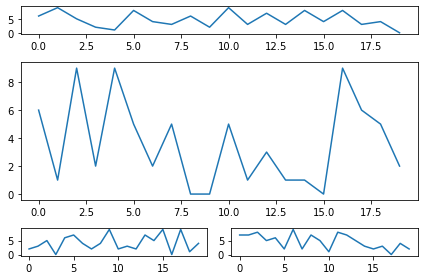

In [ ]:
def random_plots():
  xs = []
  ys = []
  
  for i in range(20):
    x = i
    y = np.random.randint(10)
    
    xs.append(x)
    ys.append(y)
  
  return xs, ys

fig = plt.figure()
ax1 = plt.subplot2grid((5, 2), (0, 0), rowspan=1, colspan=2)
ax2 = plt.subplot2grid((5, 2), (1, 0), rowspan=3, colspan=2)
ax3 = plt.subplot2grid((5, 2), (4, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((5, 2), (4, 1), rowspan=1, colspan=1)

x, y = random_plots()
ax1.plot(x, y)

x, y = random_plots()
ax2.plot(x, y)

x, y = random_plots()
ax3.plot(x, y)

x, y = random_plots()
ax4.plot(x, y)

plt.tight_layout()
plt.show()

## 3D Graphs

### 3D Scatter Plots

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = np.random.randint(10, size=10)
z1 = np.random.randint(10, size=10)

x2 = [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]
y2 = np.random.randint(-10, 0, size=10)
z2 = np.random.randint(10, size=10)

ax.scatter(x1, y1, z1, c='b', marker='o', label='blue')
ax.scatter(x2, y2, z2, c='g', marker='D', label='green')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.title("3D Scatter Plot Example")
plt.legend()
plt.tight_layout()
plt.show()

### Wireframe Plots

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x, y, z = axes3d.get_test_data()

ax.plot_wireframe(x, y, z, rstride = 2, cstride = 2)

plt.title("Wireframe Plot Example")
plt.tight_layout()
plt.show()